#**Group 10 Modeling**

---



In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import random 
import time

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.autograd import Variable


In [6]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Data Preparation**

In [3]:
#Extract data from google drive storage (extremely slow) into local notebook storage
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Group_10_CV_Project/train.zip", 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Group_10_CV_Project/test.zip", 'r')
zip_ref.extractall()
zip_ref.close()


gdrive/  sample_data/


In [8]:
def load_dataset(img_paths, label_dict, num_images, img_size, shuffle=True, is_color=False, zero_centered=True, batch_size=None, horizontal_flip=False):    
    start_time = time.time()
    data = []
    labels = []

    channels = 3 if is_color else 1

    #Shuffle data
    if shuffle:
        random.shuffle(img_paths)

    print("Paths shuffled. Time: ", time.time() - start_time)
    images = []
    #Read images and corresponding labels
    for i in range(num_images):
      
        filename = img_paths[i]
        labels.append(label_dict[filename])
        if is_color:
          img = cv2.imread(filename)
        else:
          img = cv2.imread(filename, 0)
 
        #Resize
        img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

        #Normalize
        img = img.astype(np.float)/255*2-1

        if horizontal_flip:
          flipped_img = cv2.flip(img, 1)
          flipped_img = np.reshape(flipped_img, (channels, img_size[0], img_size[1]))
          labels.append(label_dict[filename])
          data.append(flipped_img)
          
        
        img = np.reshape(img, (channels, img_size[0], img_size[1]))
        data.append(img)

    print("Images read, resized, normalized, and reshaped. Time:", time.time() - start_time)

    #Perform zero-centered regularization
    if zero_centered:
      for i in range(len(data)):
        data[i] -= np.mean(data[i])
      
      print("Images zero centered. Time: ", time.time()- start_time)
      
  
    if horizontal_flip:
      bundle = list(zip(data, labels))
      random.shuffle(bundle)
      data, labels = zip(*bundle)

    #Convert to torch tensors
    data = torch.FloatTensor(data)
    labels = torch.LongTensor(labels)

    print("Converted to torch tensors. Time: ", time.time()- start_time)

    #Create minibatches
    if batch_size is not None:
  
      data_batches = []
      label_batches = []

      total_batches = int(len(data) / batch_size)
      
      data = [data[i*batch_size: (i+1)*batch_size] for i in range(total_batches)]
      labels = [labels[i*batch_size: (i+1)*batch_size] for i in range(total_batches)]

    print("Minibatches created. Time: ", time.time()- start_time)
    return zip(data, labels)

In [9]:
#Create label dictionary: Key = filename, value = label
#Function is necessary because labels are stored in .txt file

def get_label_dict(path, img_path):

    label_file = open(path, 'r')
    lines = label_file.readlines()
    label_dict = {}
    
    print("Number of labels: ", len(lines))
    for line in lines:
      split = line.split(' ')

      if split[2] == 'normal':
        lbl = 0
      elif split[2] == 'pneumonia':
        lbl = 1
      else:
        lbl = 2

      label_dict[img_path + split[1]] = lbl

    return label_dict

#Some images do not have a label
def remove_non_labeled(paths, label_dict):

  labeled_img_paths = []
  for path in paths:
    if path in label_dict.keys():
      labeled_img_paths.append(path)

  return labeled_img_paths
  


In [10]:
project_path = './gdrive/MyDrive/Group_10_CV_Project'

train_label_dict = get_label_dict(project_path + '/Covid_Net_Data/train.txt', "./train/")
img_paths = glob.glob('./train/*')
train_img_paths = remove_non_labeled(img_paths, train_label_dict)

print("Total training images:", len(img_paths))
print("After removing non-labeled:", len(train_img_paths))



Number of labels:  30130
Total training images: 29986
After removing non-labeled: 29634


In [11]:
test_img_paths = glob.glob('./test/*')
test_label_dict = get_label_dict(project_path + '/Covid_Net_Data/test.txt', "./test/")
print("Total testing images: ", len(test_img_paths))

Number of labels:  400
Total testing images:  400


In [32]:
#Build train and test dataloaders
batch_size = 64

train_loader = list(load_dataset(train_img_paths, train_label_dict, num_images=len(train_img_paths), img_size=(128, 128), batch_size=batch_size))

test_loader = list(load_dataset(test_img_paths, test_label_dict, num_images=len(test_img_paths), img_size=(128,128), batch_size=batch_size))

Paths shuffled. Time:  0.015338420867919922


<ipython-input-8-09dc535fdf2a>:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = img.astype(np.float)/255*2-1


Images read, resized, normalized, and reshaped. Time: 325.44124007225037
Images zero centered. Time:  326.76813411712646
Converted to torch tensors. Time:  383.44126772880554
Minibatches created. Time:  383.4561471939087
Paths shuffled. Time:  0.00016570091247558594
Images read, resized, normalized, and reshaped. Time: 16.921409130096436
Images zero centered. Time:  16.938474655151367
Converted to torch tensors. Time:  17.378602027893066
Minibatches created. Time:  17.37888813018799


In [40]:
#Initialize variables to work with pytorch train method
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {}
dataset_sizes['train'] = batch_size * len(train_loader)
dataset_sizes['val'] = batch_size * len(test_loader)

In [12]:
#Choose loss function (from tutorial)
criterion = nn.CrossEntropyLoss()

#Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Pytorch Tutorial Training Method**

Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [13]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# **Metrics**

In [14]:
import torchmetrics
from torchmetrics.functional import precision, recall, accuracy
from sklearn.metrics import confusion_matrix


def get_metrics(model, testloader):
  targets = torch.empty(0, dtype=torch.uint8)
  preds = torch.empty(0, dtype=torch.uint8)

  for data, labels in testloader:
    targets = torch.cat((targets, labels))

    data = data.to(device)
    outputs = model(data).cpu()
    _, pred = torch.max(outputs, 1)
    preds = torch.cat((preds, pred))


  prec = precision(preds, targets, task='multiclass', num_classes=3, multidim_average='global', average=None)
  rec = recall(preds, targets, task='multiclass', num_classes=3, multidim_average='global', average=None)

  classes = ["Normal", "Non-COVID Pneumonia", "COVID-19 Pneumonia"]

  for i in range(3):
    print("----------------------------\n")
    print("Class", i, ":", classes[i],'\n')
    print("Precision:", prec[i].item())
    print("Recall:", rec[i].item(), "\n")

  print("----------------------------\n")  
  print("Overall Accuracy: ", accuracy(preds,targets,task='multiclass', num_classes=3).item(), "\n\n")

  conf_matrix = confusion_matrix(preds.numpy(), targets.numpy())

  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()



# **Custom Model Architecture**

In [15]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class CustomNetwork(nn.Module):
    def __init__(self):
      super(CustomNetwork,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 32, 5),
        nn.ReLU(),
        nn.MaxPool2d(8, stride=4), 
        nn.Conv2d(32, 64, 5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(64, 64, 5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Dropout(0.5)
      )
      
      self.classifier = nn.Sequential(
          nn.Linear(3136, 3)
      )

    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
     
      return x  

# **Training Custom Model**

In [40]:
custom_model = CustomNetwork()
#Use gpu if avaialble (from tutorial)
custom_model = custom_model.to(device)

# Observe that all parameters are being optimized (from tutorial)
optimizer_custom = optim.SGD(custom_model.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs (from tutorial)
exp_lr_scheduler_custom = lr_scheduler.StepLR(optimizer_custom, step_size=7, gamma=0.1)

#Train and return trained model
custom_model = train_model(custom_model, optimizer_custom, exp_lr_scheduler_custom, num_epochs=15)


Epoch 0/14
----------
train Loss: 0.5812 Acc: 0.7585
val Loss: 0.5390 Acc: 0.7500

Epoch 1/14
----------
train Loss: 0.4299 Acc: 0.8355
val Loss: 0.4827 Acc: 0.7943

Epoch 2/14
----------
train Loss: 0.3745 Acc: 0.8554
val Loss: 0.4502 Acc: 0.7839

Epoch 3/14
----------
train Loss: 0.3362 Acc: 0.8715
val Loss: 0.3430 Acc: 0.8385

Epoch 4/14
----------
train Loss: 0.3034 Acc: 0.8846
val Loss: 0.3347 Acc: 0.8672

Epoch 5/14
----------
train Loss: 0.2811 Acc: 0.8933
val Loss: 0.3468 Acc: 0.8672

Epoch 6/14
----------
train Loss: 0.2608 Acc: 0.9003
val Loss: 0.3105 Acc: 0.8958

Epoch 7/14
----------
train Loss: 0.2224 Acc: 0.9173
val Loss: 0.2666 Acc: 0.9036

Epoch 8/14
----------
train Loss: 0.2156 Acc: 0.9193
val Loss: 0.2664 Acc: 0.9141

Epoch 9/14
----------
train Loss: 0.2129 Acc: 0.9218
val Loss: 0.2601 Acc: 0.9141

Epoch 10/14
----------
train Loss: 0.2107 Acc: 0.9229
val Loss: 0.2589 Acc: 0.9141

Epoch 11/14
----------
train Loss: 0.2088 Acc: 0.9230
val Loss: 0.2530 Acc: 0.9193

Ep

**Save Custom Model to Notebook Storage**

In [31]:
torch.save(custom_model.state_dict(), "custom_model_state_dict.pt")

----------------------------

Class 0 : Normal 

Precision: 0.8103448152542114
Recall: 0.969072163105011 

----------------------------

Class 1 : Non-COVID Pneumonia 

Precision: 0.931034505367279
Recall: 0.8526315689086914 

----------------------------

Class 2 : COVID-19 Pneumonia 

Precision: 0.9779005646705627
Recall: 0.921875 

----------------------------

Overall Accuracy:  0.9166666865348816 




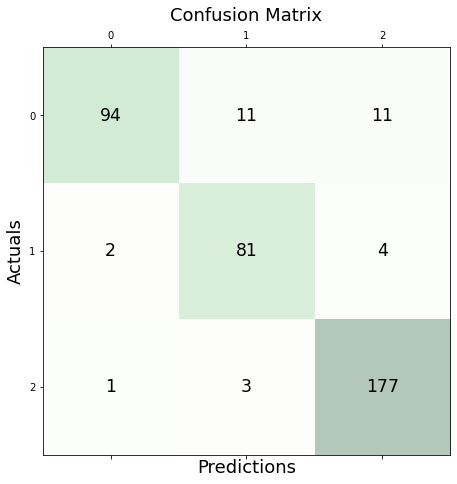

In [43]:
#Load best model (same architecture and hyperparameters as above)

loaded_dict = torch.load("/content/gdrive/My Drive/Group_10_CV_Project/custom_model_state_dict_94.pt", map_location=torch.device('cpu'))
custom_model.load_state_dict(loaded_dict)

get_metrics(custom_model, test_loader)
    

# **Pretrained models**

<br>


---

<br>

**Data-Prep:**

In [16]:
#Data Prep

batch_size = 64

pre_train_loader = list(load_dataset(train_img_paths, train_label_dict, num_images=10000, img_size=(224, 224), batch_size=batch_size, is_color=True))

pre_test_loader = list(load_dataset(test_img_paths, test_label_dict, num_images=len(test_img_paths), img_size=(224,224), batch_size=batch_size, is_color=True))

dataloaders = {}
dataloaders['train'] = pre_train_loader
dataloaders['val'] = pre_test_loader

dataset_sizes = {}
dataset_sizes['train'] = batch_size * len(pre_train_loader)
dataset_sizes['val'] = batch_size * len(pre_test_loader)



Paths shuffled. Time:  0.015599966049194336


<ipython-input-8-09dc535fdf2a>:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = img.astype(np.float)/255*2-1


Images read, resized, normalized, and reshaped. Time: 134.64470720291138
Images zero centered. Time:  137.38223886489868


<ipython-input-8-09dc535fdf2a>:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data = torch.FloatTensor(data)


Converted to torch tensors. Time:  243.39582204818726
Minibatches created. Time:  243.4228537082672
Paths shuffled. Time:  0.0001773834228515625
Images read, resized, normalized, and reshaped. Time: 21.22289538383484
Images zero centered. Time:  21.30060362815857
Converted to torch tensors. Time:  24.595335960388184
Minibatches created. Time:  24.595584630966187


**Fine-Tuning Resnet18**

In [19]:
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler


model_res18 = models.resnet18(pretrained=True)

for param in model_res18.parameters():
    param.requires_grad = True

num_ftrs = model_res18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_res18.fc = nn.Linear(num_ftrs, 3)

model_res18 = model_res18.to(device)

# Observe that all parameters are being optimized
optimizer_res18 = optim.SGD(model_res18.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_res18 = lr_scheduler.StepLR(optimizer_res18, step_size=7, gamma=0.1)

model_res18 = train_model(model_res18, optimizer_res18, exp_lr_scheduler_res18, num_epochs=15)



Epoch 0/14
----------
train Loss: 0.4695 Acc: 0.8093
val Loss: 0.4825 Acc: 0.7995

Epoch 1/14
----------
train Loss: 0.2336 Acc: 0.9139
val Loss: 0.4440 Acc: 0.8464

Epoch 2/14
----------
train Loss: 0.1258 Acc: 0.9582
val Loss: 0.4527 Acc: 0.8490

Epoch 3/14
----------
train Loss: 0.0584 Acc: 0.9861
val Loss: 0.5008 Acc: 0.8411

Epoch 4/14
----------
train Loss: 0.0281 Acc: 0.9945
val Loss: 0.5545 Acc: 0.8490

Epoch 5/14
----------
train Loss: 0.0166 Acc: 0.9972
val Loss: 0.5170 Acc: 0.8516

Epoch 6/14
----------
train Loss: 0.0076 Acc: 0.9993
val Loss: 0.5233 Acc: 0.8828

Epoch 7/14
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.5365 Acc: 0.8594

Epoch 8/14
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.5391 Acc: 0.8594

Epoch 9/14
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.5404 Acc: 0.8620

Epoch 10/14
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.5413 Acc: 0.8646

Epoch 11/14
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.5422 Acc: 0.8646

Ep

----------------------------

Class 0 : Normal 

Precision: 0.817307710647583
Recall: 0.8854166865348816 

----------------------------

Class 1 : Non-COVID Pneumonia 

Precision: 0.8617021441459656
Recall: 0.8265306353569031 

----------------------------

Class 2 : COVID-19 Pneumonia 

Precision: 0.9301075339317322
Recall: 0.9105263352394104 

----------------------------

Overall Accuracy:  0.8828125 




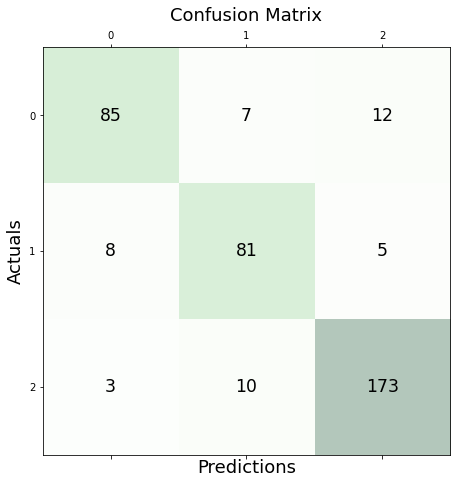

In [21]:
get_metrics(model_res18, pre_test_loader)

**ResNet18 as Fixed Feature Extractor:**

In [22]:
model_res18_extractor = models.resnet18(pretrained=True)

for param in model_res18_extractor.parameters():
    param.requires_grad = False

num_ftrs = model_res18_extractor.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_res18_extractor.fc = nn.Linear(num_ftrs, 3)

model_res18_extractor = model_res18_extractor.to(device)

# Observe that all parameters are being optimized
optimizer_res18_extractor = optim.SGD(model_res18_extractor.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_res18_extractor = lr_scheduler.StepLR(optimizer_res18_extractor, step_size=7, gamma=0.1)

model_res18_extractor = train_model(model_res18_extractor, optimizer_res18_extractor, exp_lr_scheduler_res18_extractor, num_epochs=15)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/14
----------
train Loss: 0.6478 Acc: 0.7216
val Loss: 0.6056 Acc: 0.7656

Epoch 1/14
----------
train Loss: 0.5194 Acc: 0.7878
val Loss: 0.5682 Acc: 0.7630

Epoch 2/14
----------
train Loss: 0.4957 Acc: 0.7972
val Loss: 0.5541 Acc: 0.7708

Epoch 3/14
----------
train Loss: 0.4822 Acc: 0.8043
val Loss: 0.5482 Acc: 0.7656

Epoch 4/14
----------
train Loss: 0.4729 Acc: 0.8095
val Loss: 0.5456 Acc: 0.7708

Epoch 5/14
----------
train Loss: 0.4657 Acc: 0.8127
val Loss: 0.5446 Acc: 0.7682

Epoch 6/14
----------
train Loss: 0.4600 Acc: 0.8150
val Loss: 0.5443 Acc: 0.7708

Epoch 7/14
----------
train Loss: 0.4332 Acc: 0.8276
val Loss: 0.5446 Acc: 0.7969

Epoch 8/14
----------
train Loss: 0.4322 Acc: 0.8286
val Loss: 0.5450 Acc: 0.7969

Epoch 9/14
----------
train Loss: 0.4317 Acc: 0.8289
val Loss: 0.5453 Acc: 0.7969

Epoch 10/14
----------
train Loss: 0.4312 Acc: 0.8293
val Loss: 0.5456 Acc: 0.7969

Epoch 11/14
----------
train Loss: 0.4308 Acc: 0.8293
val Loss: 0.5457 Acc: 0.7969

Ep

----------------------------

Class 0 : Normal 

Precision: 0.6890756487846375
Recall: 0.8541666865348816 

----------------------------

Class 1 : Non-COVID Pneumonia 

Precision: 0.7777777910232544
Recall: 0.7142857313156128 

----------------------------

Class 2 : COVID-19 Pneumonia 

Precision: 0.8799999952316284
Recall: 0.8105263113975525 

----------------------------

Overall Accuracy:  0.796875 




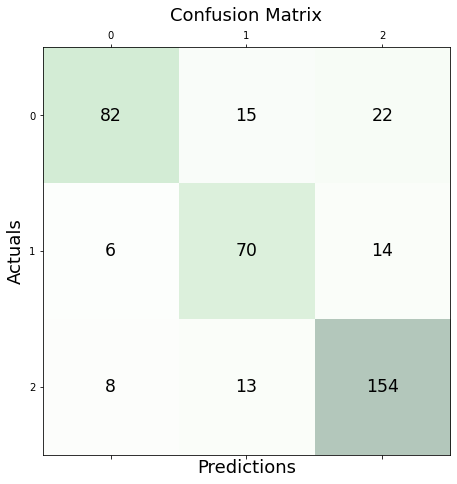

In [23]:
get_metrics(model_res18_extractor, pre_test_loader)

**Fine-Tuning AlexNet**



In [25]:

model_alex = models.alexnet(pretrained=True)

for param in model_alex.parameters():
    param.requires_grad = True

num_ftrs = model_alex.classifier[6].in_features
model_alex.classifier[6] = nn.Linear(num_ftrs, 3)

model_alex = model_alex.to(device)

# Observe that all parameters are being optimized
optimizer_alex = optim.SGD(model_alex.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_alex = lr_scheduler.StepLR(optimizer_alex, step_size=7, gamma=0.1)

model_alex = train_model(model_alex, optimizer_alex, exp_lr_scheduler_alex, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.6428 Acc: 0.7251
val Loss: 0.8588 Acc: 0.6120

Epoch 1/14
----------
train Loss: 0.4746 Acc: 0.8119
val Loss: 0.5221 Acc: 0.7969

Epoch 2/14
----------
train Loss: 0.4145 Acc: 0.8379
val Loss: 0.5888 Acc: 0.7656

Epoch 3/14
----------
train Loss: 0.3672 Acc: 0.8559
val Loss: 0.5197 Acc: 0.8021

Epoch 4/14
----------
train Loss: 0.3319 Acc: 0.8714
val Loss: 0.4822 Acc: 0.8047

Epoch 5/14
----------
train Loss: 0.2952 Acc: 0.8897
val Loss: 0.4918 Acc: 0.8047

Epoch 6/14
----------
train Loss: 0.2780 Acc: 0.8919
val Loss: 0.4433 Acc: 0.8229

Epoch 7/14
----------
train Loss: 0.2236 Acc: 0.9171
val Loss: 0.4202 Acc: 0.8359

Epoch 8/14
----------
train Loss: 0.2112 Acc: 0.9196
val Loss: 0.4249 Acc: 0.8333

Epoch 9/14
----------
train Loss: 0.2065 Acc: 0.9223
val Loss: 0.4198 Acc: 0.8464

Epoch 10/14
----------
train Loss: 0.1995 Acc: 0.9239
val Loss: 0.4327 Acc: 0.8438

Epoch 11/14
----------
train Loss: 0.1964 Acc: 0.9258
val Loss: 0.4253 Acc: 0.8333

Ep

----------------------------

Class 0 : Normal 

Precision: 0.761904776096344
Recall: 0.8333333134651184 

----------------------------

Class 1 : Non-COVID Pneumonia 

Precision: 0.8488371968269348
Recall: 0.7448979616165161 

----------------------------

Class 2 : COVID-19 Pneumonia 

Precision: 0.8911917209625244
Recall: 0.9052631855010986 

----------------------------

Overall Accuracy:  0.8463541865348816 




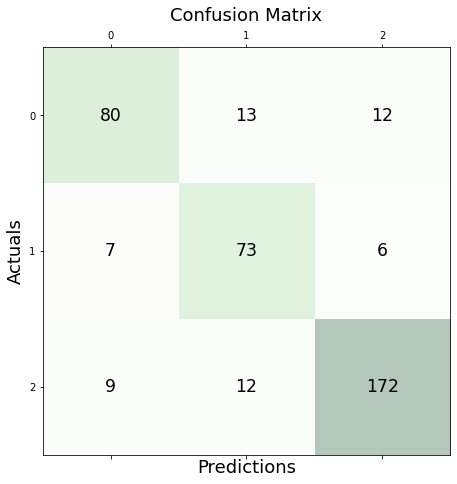

In [26]:
get_metrics(model_alex, pre_test_loader)

**AlexNet as fixed feature extractor**

In [27]:

model_alex_ft = models.alexnet(pretrained=True)

for param in model_alex_ft.parameters():
    param.requires_grad = False

num_ftrs = model_alex_ft.classifier[6].in_features
model_alex_ft.classifier[6] = nn.Linear(num_ftrs, 3)

model_alex_ft = model_alex_ft.to(device)

# Observe that all parameters are being optimized
optimizer_alex_ft = optim.SGD(model_alex_ft.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_alex_ft = lr_scheduler.StepLR(optimizer_alex_ft, step_size=7, gamma=0.1)

model_alex_ft = train_model(model_alex_ft, optimizer_alex_ft, exp_lr_scheduler_alex_ft, num_epochs=15)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/14
----------
train Loss: 0.7652 Acc: 0.6758
val Loss: 1.0342 Acc: 0.5026

Epoch 1/14
----------
train Loss: 0.7335 Acc: 0.6936
val Loss: 0.9528 Acc: 0.5156

Epoch 2/14
----------
train Loss: 0.7441 Acc: 0.6920
val Loss: 0.9588 Acc: 0.5234

Epoch 3/14
----------
train Loss: 0.7093 Acc: 0.7036
val Loss: 0.9194 Acc: 0.5417

Epoch 4/14
----------
train Loss: 0.7269 Acc: 0.6984
val Loss: 1.1480 Acc: 0.4609

Epoch 5/14
----------
train Loss: 0.7103 Acc: 0.7038
val Loss: 0.9420 Acc: 0.5495

Epoch 6/14
----------
train Loss: 0.7269 Acc: 0.7016
val Loss: 1.2543 Acc: 0.4661

Epoch 7/14
----------
train Loss: 0.6451 Acc: 0.7241
val Loss: 0.7826 Acc: 0.6484

Epoch 8/14
----------
train Loss: 0.6370 Acc: 0.7286
val Loss: 0.7754 Acc: 0.6589

Epoch 9/14
----------
train Loss: 0.6323 Acc: 0.7308
val Loss: 0.7957 Acc: 0.6536

Epoch 10/14
----------
train Loss: 0.6334 Acc: 0.7272
val Loss: 0.7852 Acc: 0.6536

Epoch 11/14
----------
train Loss: 0.6302 Acc: 0.7304
val Loss: 0.7726 Acc: 0.6641

Ep

----------------------------

Class 0 : Normal 

Precision: 0.5454545617103577
Recall: 0.8125 

----------------------------

Class 1 : Non-COVID Pneumonia 

Precision: 0.8333333134651184
Recall: 0.40816327929496765 

----------------------------

Class 2 : COVID-19 Pneumonia 

Precision: 0.7202072739601135
Recall: 0.7315789461135864 

----------------------------

Overall Accuracy:  0.6692708134651184 




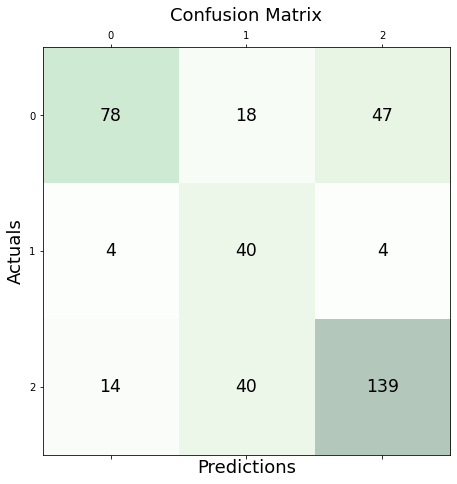

In [28]:
get_metrics(model_alex_ft, pre_test_loader)

**Fine Tuning VGG-16**

In [29]:
model_vgg16 = models.vgg16(pretrained=True)

for param in model_vgg16.parameters():
    param.requires_grad = True

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, 3)

model_vgg16 = model_vgg16.to(device)

# Observe that all parameters are being optimized
optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_vgg16 = lr_scheduler.StepLR(optimizer_vgg16, step_size=7, gamma=0.1)

model_vgg16 = train_model(model_vgg16, optimizer_vgg16, exp_lr_scheduler_vgg16, num_epochs=15)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoch 0/14
----------
train Loss: 0.5501 Acc: 0.7675
val Loss: 0.6105 Acc: 0.7552

Epoch 1/14
----------
train Loss: 0.3324 Acc: 0.8721
val Loss: 0.5540 Acc: 0.8021

Epoch 2/14
----------
train Loss: 0.2756 Acc: 0.8961
val Loss: 0.6244 Acc: 0.7656

Epoch 3/14
----------
train Loss: 0.2402 Acc: 0.9084
val Loss: 0.7181 Acc: 0.7526

Epoch 4/14
----------
train Loss: 0.2018 Acc: 0.9224
val Loss: 0.5030 Acc: 0.8385

Epoch 5/14
----------
train Loss: 0.1877 Acc: 0.9286
val Loss: 0.8614 Acc: 0.7448

Epoch 6/14
----------
train Loss: 0.1687 Acc: 0.9346
val Loss: 0.5278 Acc: 0.8125

Epoch 7/14
----------
train Loss: 0.1173 Acc: 0.9566
val Loss: 0.3985 Acc: 0.8698

Epoch 8/14
----------
train Loss: 0.1012 Acc: 0.9604
val Loss: 0.3841 Acc: 0.8802

Epoch 9/14
----------
train Loss: 0.0913 Acc: 0.9662
val Loss: 0.4162 Acc: 0.8698

Epoch 10/14
----------
train Loss: 0.0855 Acc: 0.9693
val Loss: 0.3985 Acc: 0.8750

Epoch 11/14
----------
train Loss: 0.0763 Acc: 0.9716
val Loss: 0.4090 Acc: 0.8802

Ep

----------------------------

Class 0 : Normal 

Precision: 0.8181818127632141
Recall: 0.84375 

----------------------------

Class 1 : Non-COVID Pneumonia 

Precision: 0.7943925261497498
Recall: 0.8673469424247742 

----------------------------

Class 2 : COVID-19 Pneumonia 

Precision: 0.9719101190567017
Recall: 0.9105263352394104 

----------------------------

Overall Accuracy:  0.8828125 




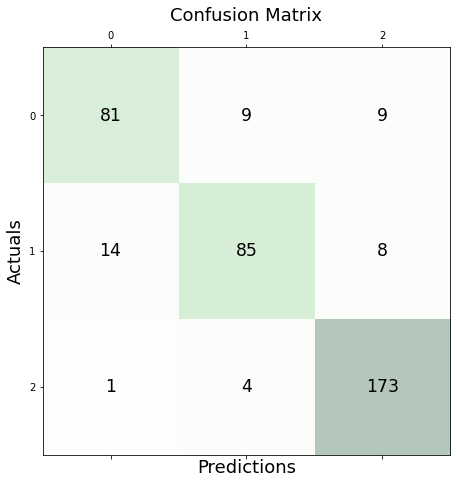

In [30]:
get_metrics(model_vgg16, pre_test_loader)

**VGG-16 as Fixed Feature Extractor**


In [31]:
model_vgg16_ft = models.vgg16(pretrained=True)

for param in model_vgg16_ft.parameters():
    param.requires_grad = False

num_ftrs = model_vgg16_ft.classifier[6].in_features
model_vgg16_ft.classifier[6] = nn.Linear(num_ftrs, 3)

model_vgg16_ft = model_vgg16_ft.to(device)

# Observe that all parameters are being optimized
optimizer_vgg16_ft = optim.SGD(model_vgg16_ft.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_vgg16_ft = lr_scheduler.StepLR(optimizer_vgg16_ft, step_size=7, gamma=0.1)

model_vgg16_ft = train_model(model_vgg16_ft, optimizer_vgg16_ft, exp_lr_scheduler_vgg16_ft, num_epochs=15)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/14
----------
train Loss: 0.7894 Acc: 0.6326
val Loss: 1.0136 Acc: 0.4635

Epoch 1/14
----------
train Loss: 0.7390 Acc: 0.6588
val Loss: 0.9910 Acc: 0.4792

Epoch 2/14
----------
train Loss: 0.7276 Acc: 0.6739
val Loss: 0.9750 Acc: 0.5078

Epoch 3/14
----------
train Loss: 0.7193 Acc: 0.6760
val Loss: 0.9617 Acc: 0.5182

Epoch 4/14
----------
train Loss: 0.7150 Acc: 0.6810
val Loss: 1.0353 Acc: 0.4714

Epoch 5/14
----------
train Loss: 0.7167 Acc: 0.6734
val Loss: 1.0074 Acc: 0.5026

Epoch 6/14
----------
train Loss: 0.7126 Acc: 0.6791
val Loss: 0.9880 Acc: 0.4818

Epoch 7/14
----------
train Loss: 0.6919 Acc: 0.6919
val Loss: 0.8479 Acc: 0.6016

Epoch 8/14
----------
train Loss: 0.6897 Acc: 0.6911
val Loss: 0.8533 Acc: 0.5990

Epoch 9/14
----------
train Loss: 0.6908 Acc: 0.6898
val Loss: 0.8513 Acc: 0.6016

Epoch 10/14
----------
train Loss: 0.6840 Acc: 0.6961
val Loss: 0.8542 Acc: 0.5990

Epoch 11/14
----------
train Loss: 0.6822 Acc: 0.6943
val Loss: 0.8630 Acc: 0.5885

Ep

----------------------------

Class 0 : Normal 

Precision: 0.8367347121238708
Recall: 0.42268040776252747 

----------------------------

Class 1 : Non-COVID Pneumonia 

Precision: 1.0
Recall: 0.010204081423580647 

----------------------------

Class 2 : COVID-19 Pneumonia 

Precision: 0.559880256652832
Recall: 0.9894179701805115 

----------------------------

Overall Accuracy:  0.5963541865348816 




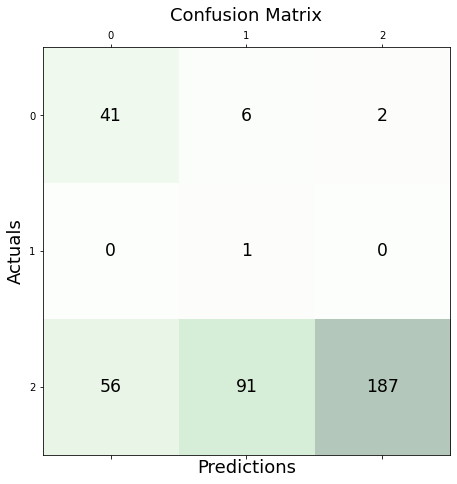

In [ ]:
get_metrics(model_vgg16_ft, pre_test_loader)

# **Results**


---


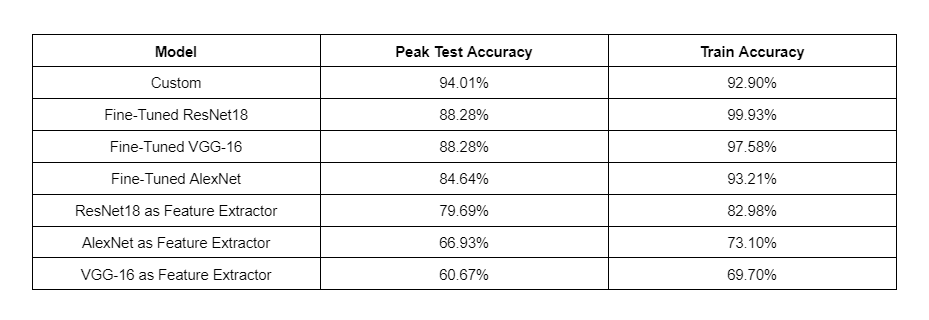

# **Custom Model Description**

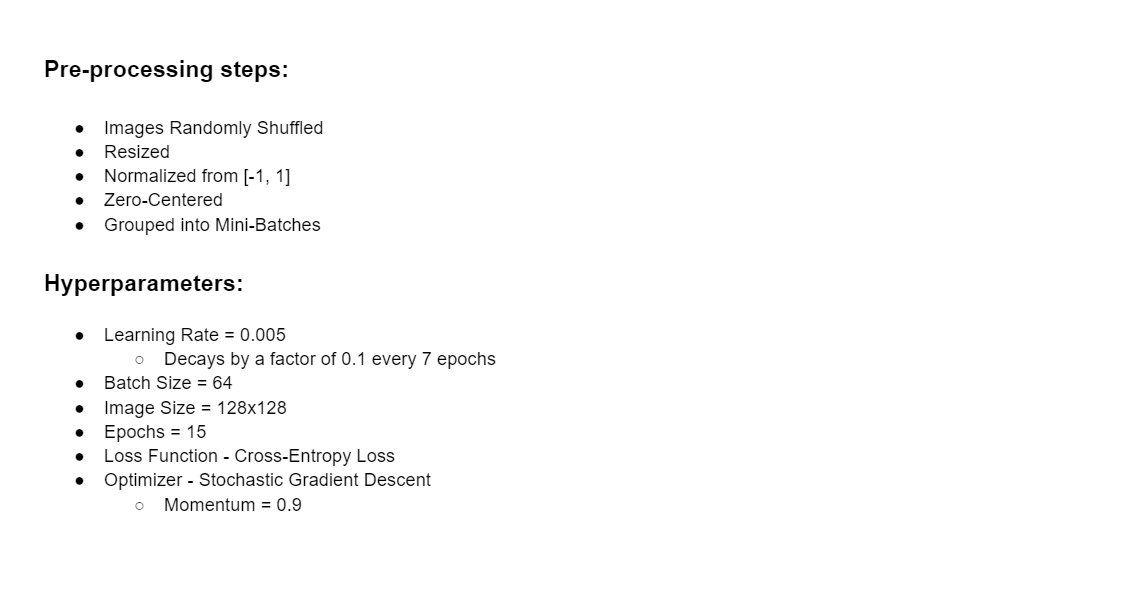

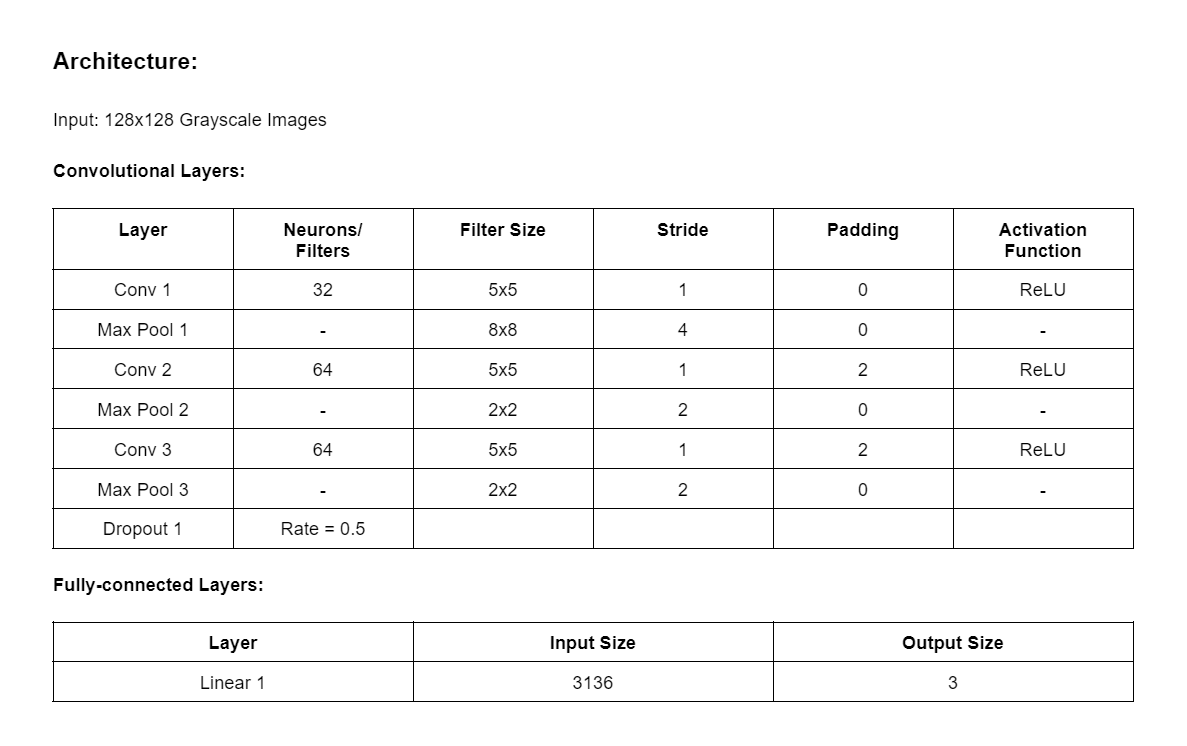

# **Literature Review**

Based on our research, it was clear the foremost strategy for this kind of medical image classificiation is the use of Deep Convolutional Neural Networks. Approaches involving pre-trained models and custom models both showed promise, so we set out to explore both options. For our pretrained models, we chose ResNet18 and VGG16 because they performed well based on the literature we reviewed, and AlexNet because we wanted to try something new that did not show up in our research. 


# **Experimentation**

**Libraries and tools used:** 


*   OpenCV - Image preprocessing
*   PyTorch - Modeling and training
*   SciKit-Learn & Matplotlib - Metrics

**Datasets Information:**

*   Total # of training images: 29,634
*   Total # of testing images: 384

**Experimental Process**

In order to build a custom model from scratch, we first took inspiration from the architecture of pretrained models and custom models that showed up in our research. Once we had a starting point, we experimented with different pre-processing options, hyperparameters, and architectures. We kept track of what seemed to be increasing/decreasing model performance. Here is an extensive list of the options we calibrated to optimize accuracy:

*   Data augmentation (horizontal flip)
*   Zero-centering
*   Batch size
*   Image size
*   Learning rate
*   Learning rate decay
*   Optimizer algorithm
*   Number of epochs
*   Number of convolutional layers
*   Number of max pool layers
*   Kernel sizes
*   Stride lengths
*   Padding amount
*   Number of filters
*   Batch normalization layers
*   Number and position of dropout layers
*   Dropout rate
*   Activation functions
*   Number of fully connected layers
*   Number of input/output neurons

<br>

The final custom model (as described above) is the culmination of our intuition based experimentation involving all of these factors. 

<br>



